In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import scipy

from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/wujingyi/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/wujingyi/miniconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/wujingyi/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_s

In [2]:
train_df = pd.read_csv('./dataset/cleaned_train_2.csv', 
                 header = 0, 
                 names = ['user', 'movie','rating'], 
                 usecols = [0,1,2])

test_df = pd.read_csv('./dataset/cleaned_test_2.csv', 
                 header = 0, 
                 names = ['user', 'movie','rating'], 
                 usecols = [0,1,2])

In [188]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, user_item_pairs, ratings):
        'Initialization'
        self.labels  = ratings
        self.samples = user_item_pairs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.samples)

    def __getitem__(self, index):
        'Generates one sample of data'
        # # Load data and get label
        #print("called get item")
        user_item_pair = self.samples[index].astype('long')
        user_social = np.zeros(64).astype('long') #convert to actual social embeddings later
        user_item_pair_social = np.concatenate((user_item_pair, user_social), axis=None)
        X = user_item_pair_social
        y = self.labels[index]
        return X, y

In [189]:
class MLP(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8,layers = [16,32,16,8]):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=layers[-1], out_features=1)
#         self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
#         print("item_embedding")
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
#         print("vector",vector)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        out = self.affine_output(vector)
#         rating = self.logistic(logits)
        return out


In [190]:
def predict(model, generator):
    model.eval()
    y_preds_all = torch.Tensor().to(device) 
    y_labels_all = torch.Tensor().to(device) 
    for local_batch, local_labels in generator:
        local_batch  = torch.tensor(local_batch).type(torch.long).to(device)
        local_labels = local_labels.type(torch.float).to(device)
        with torch.no_grad():
            y_preds = model(local_batch[:,0], local_batch[:,1])
        y_preds_all = torch.cat((y_preds_all,y_preds))
        y_labels_all = torch.cat((y_labels_all,local_labels))
    return y_preds_all, y_labels_all
def evaluate(model, generator):
    y_preds_all, y_labels_all = predict(model, generator)  
    y_preds = list(y_preds_all.view(1, y_preds_all.size()[0]).to("cpu").numpy()[0])
    y_actuals = list(y_labels_all.view(1, y_labels_all.size()[0]).to("cpu").numpy()[0])
    print(np.array([y_preds,y_actuals]))
    #print(type(y_preds), type(y_actuals))
    tmse = sum([(a-b) * (a-b) for a,b in zip(y_preds, y_actuals)])
    rmse = math.sqrt((1.0*tmse)/len(y_preds))
    return rmse

In [ ]:

def epoch_run(model, generator, opt, criterion, mode="train"):
    running_loss = 0
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    #for local_batch, local_labels in generator:
    for local_batch, local_labels  in generator:
        local_batch  = torch.tensor(local_batch).type(torch.long).to(device)
        local_labels = local_labels.type(torch.float).to(device)
        
        y_preds = model(local_batch[:,0], local_batch[:,1])
        loss = criterion(y_preds, local_labels)
        
        running_loss += (loss.item()*local_labels.size()[0])
        
        if(mode == "train"):
            opt.zero_grad()
            loss.backward()
            opt.step()
            print("loss:",loss)
    avg_loss = running_loss * 1.0 / (len(generator.dataset))
    return avg_loss

In [192]:
def prepro(df):
    df[['rating']]=df[['rating']].astype(float)
    df[['user']]=df[['user']].astype(int)
    df[['movie']]=df[['movie']].astype(int)
    
    user_id = df[['user']].drop_duplicates().reset_index(drop=True).reset_index()
    item_id = df[['movie']].drop_duplicates()
    user_id.rename(columns={'index':'user_id'},inplace=True)
    subset = df.merge(user_id,"left",on = "user")[['user_id', 'movie', 'rating']]
    
#     print(subset)
    num_users = int(len(user_id)+1)
#     num_users = int(user_id['user'].max() - user_id['user'].min() + 1)
    num_items = int(item_id['movie'].max()  + 1)
    # num_items = int(len(item_id))
    print("num_users: ",num_users,"num_items: ", num_items)
    
#     subset = df[['user', 'movie', 'rating']]
    total_ratings = np.array(subset.values)
    user_item_pairs = total_ratings[:,0:2]
    ratings = total_ratings[:,2:3]
    return total_ratings,user_item_pairs,ratings,num_users,num_items

In [193]:
# prepro(train_df[900:1000])
# train_df[:10]

In [218]:
BATCH_SIZE = 10240
EPOCH = 100
training_params = {'batch_size': BATCH_SIZE,'shuffle': True,'num_workers': 0}

In [219]:
total_ratings,user_item_pairs,ratings,num_users,num_items = prepro(train_df)
train_dataset = Dataset(user_item_pairs,ratings)
total_ratings_test,user_item_pairs_test,ratings_test,_,_ = prepro(test_df)
test_dataset = Dataset(user_item_pairs_test,ratings_test)

num_users:  131099 num_items:  4500
num_users:  14567 num_items:  4500


In [220]:
train_generator = torch.utils.data.DataLoader(train_dataset, **training_params)
test_generator = torch.utils.data.DataLoader(test_dataset, **training_params)

model = MLP(num_users,num_items).to(device)
opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=1e-4)
criterion = torch.nn.MSELoss()

In [221]:
# ll = None
# for local_batch, local_labels  in train_generator:
# #     print(local_batch)
# #     print(local_batch[:,0])
# #     print(local_batch[:,1])
# #     print(local_batch[:,2])
#     ll = local_batch
#     y_preds = model(local_batch[:,0], local_batch[:,1])
#     print(y_preds)

In [222]:
# ll[:,1].shape

In [223]:
loss_ = []
loss_t = []
for epoch in range(EPOCH):
    print("epoch: ", epoch)
    train_mse = epoch_run(model, train_generator, opt, criterion,"train")
    val_mse = epoch_run(model, test_generator, opt, criterion, "val")
    loss_.append(train_mse)
    loss_t.append(val_mse)
    print("train loss: ", train_mse)
    print("val loss: ", val_mse)

epoch:  0
t loss:  1.4815840749005265
epoch:  1


KeyboardInterrupt: 

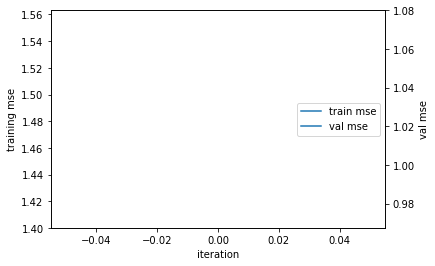

In [224]:
eps = len(loss_)
# MSE plot
fig2, ax2 = plt.subplots()
ax3 = ax2.twinx()
lns2 = ax2.plot(np.arange(eps), loss_, label="Loss")
lns3 = ax3.plot(np.arange(eps), loss_t, label="Loss")

ax2.set_xlabel('iteration')
ax2.set_ylabel('training mse')
ax3.set_ylabel('val mse')
lns = lns3 + lns2
labels = ["train mse", "val mse"]
plt.legend(lns, labels, loc=7)

plt.show()

In [211]:
# evaluate(model,test_generator)

In [225]:
# 保存
torch.save(model.state_dict(), './models/mfmlp.pkl')
# 加载
# model = TheModelClass(...)
# model.load_state_dict(torch.load('\parameter.pkl'))